In [57]:
class Config:
    name = "EDA/RFE"

    n_splits = 5
    seed = 2022
    target = "target"

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/workspace/kaggle.json"
    drive_path = "/content/drive/MyDrive/workspace/kaggle-amex"

    # Kaggle Env
    kaggle_dataset_path = None

    # Reka Env
    dir_path = '/home/abe/kaggle/kaggle-amex'

In [58]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys
import gc
import multiprocessing
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
tqdm.pandas()
warnings.filterwarnings('ignore')

## Environment Settings

In [59]:
INPUT = os.path.join(Config.dir_path, 'input')
OUTPUT = os.path.join(Config.dir_path, 'output')
SUBMISSION = os.path.join(Config.dir_path, 'submissions')
OUTPUT_EXP = os.path.join(OUTPUT, Config.name)
EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

# make dirs
for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
    os.makedirs(d, exist_ok=True)

## Load data

In [60]:
train = pd.read_pickle(os.path.join(INPUT, 'train_agg.pkl'), compression='gzip')
test = pd.read_pickle(os.path.join(INPUT, 'test_agg.pkl'), compression='gzip')
train = train.sample(10000)
test = test.sample(15000)

In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 10000 entries, c0df518a8312f4e028c48cbef78f373c5ad8624cef578b8c92c793ddf05a7a35 to ab01df611910047ac0234f16ffb58cfb7db7d7b88667f51c68b23697df3986d5
Columns: 919 entries, P_2_mean to target
dtypes: category(2), float16(713), float64(178), int64(22), int8(4)
memory usage: 48.6 MB


In [62]:
train.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
c0df518a8312f4e028c48cbef78f373c5ad8624cef578b8c92c793ddf05a7a35,0.268799,0.062082,0.171265,0.374512,0.297852,0.100098,0.172330,0.000100,0.589355,0.009224,...,13,O,2,0,NaN,0,13,5.0,3,0
3b48daf7768d119de5f70c62d5a9fe423a5ffb6acf119703b65c5ed67f0b538b,0.897949,0.049184,0.777344,0.949219,0.777344,0.004288,0.002242,0.001054,0.007381,0.007023,...,13,R,2,0,NaN,0,13,6.0,2,0
41f965752b51a9f2a1db797cd1b511f4e8cc8e9144f7e03b4bd6bce9f6b64753,0.630371,0.013484,0.600098,0.648926,0.643066,0.306396,0.261945,0.006138,0.766113,0.245117,...,13,O,1,0,NaN,0,13,5.0,1,0
9ebd81467dfcfb8748053f03e5030f5f795ec851bb1790b6124f63ab1cc88768,0.346436,0.111094,0.215454,0.529297,0.529297,0.319336,0.354117,0.008812,0.949219,0.008812,...,13,O,1,13,1.0,1,13,6.0,1,0
69d0b189f3a0e5780c373aa03ada5875e2aaf4976905ecc9d33828b52314fbad,0.376709,0.014654,0.352295,0.397461,0.352295,0.192017,0.276401,0.001155,0.627441,0.598145,...,13,R,1,0,NaN,0,13,3.0,3,1


## Evaluation Metric

In [63]:
# https://www.kaggle.com/code/inversion/amex-competition-metric-python

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(pd.DataFrame({'target': y_true}), pd.Series(y_pred, name='prediction')),
            True)

## Transform data type

In [64]:
float64_cols = [col for col in train.columns if train[col].dtype == 'float64']
int64_cols = [col for col in train.columns if train[col].dtype == 'int64']

print(train.info())
print(test.info())
print()
print("-"*50+f' data type transformation '+'-'*50)
print()

def transform_dtype(df):
  for col in df.columns:
    if df[col].dtype == 'float64':
      df[col] = df[col].astype('float16')
    if df[col].dtype == 'float32':
      df[col] = df[col].astype('float16')
    if df[col].dtype == 'int64':
      df[col] = df[col].astype('int8')
    if df[col].dtype == 'int32':
      df[col] = df[col].astype('int8')
  return df

train = transform_dtype(train)
test = transform_dtype(test)

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 10000 entries, c0df518a8312f4e028c48cbef78f373c5ad8624cef578b8c92c793ddf05a7a35 to ab01df611910047ac0234f16ffb58cfb7db7d7b88667f51c68b23697df3986d5
Columns: 919 entries, P_2_mean to target
dtypes: category(2), float16(713), float64(178), int64(22), int8(4)
memory usage: 48.6 MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 15000 entries, 470acb9ddb7288616024871121ed4e27795b7efdf0e48a7226c43be1e9f96f45 to 07ed2b6e7ef2abc8b195ceba7e5920e50be9b6f4cc9475218a8ab2ad77b6a7cd
Columns: 918 entries, P_2_mean to D_68_nunique
dtypes: category(2), float16(713), float64(178), int32(3), int64(22)
memory usage: 82.8 MB
None

-------------------------------------------------- data type transformation --------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 10000 entries, c0df518a8312f4e028c48cbef78f373c5ad8624cef578b8c92c793ddf05a7a35 to ab01df611910047ac0234f16ffb58cfb7db7d7b88667f

## Prerocess

In [65]:
from sklearn.preprocessing import LabelEncoder
cat_cols = [col for col in train.columns if train[col].dtype == 'category']

for col in cat_cols:
    le = LabelEncoder()
    le.fit(train[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

## Select Features to Use

In [66]:
features = []
unuse = ['target', 'customer_ID', 'S_2']

for col in train.columns:
  if col not in unuse:
    features.append(col)

# print(features)

## Forward Selection

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train[features].values, train[Config.target].values,
                 train_size=0.8, 
                 random_state=Config.seed, 
                 shuffle=True)

In [68]:
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier, early_stopping

lgb_params = {"learning_rate": 0.01,
              'num_leaves': 127,
              'min_child_samples': 2400}

fit_params = {
    'callbacks': [early_stopping(stopping_rounds=10, verbose=0)],
    'eval_set': [(X_test, y_test)],
    'eval_metric': lgb_amex_metric,
    'verbose': 0
}

model = LGBMClassifier(**lgb_params,
                       boosting_type='gbdt',
                       objective='binary',
                       n_estimators=10000,
                       random_state=Config.seed,
                       force_col_wise=True,
                       n_jobs=8,
                       verbose=-1)

rfe = RFE(model,
          n_features_to_select=100,
          step=4,
          verbose=1)

rfe.fit(X_train, y_train, **fit_params)

Fitting estimator with 918 features.
Fitting estimator with 914 features.
Fitting estimator with 910 features.
Fitting estimator with 906 features.
Fitting estimator with 902 features.
Fitting estimator with 898 features.
Fitting estimator with 894 features.
Fitting estimator with 890 features.
Fitting estimator with 886 features.
Fitting estimator with 882 features.
Fitting estimator with 878 features.
Fitting estimator with 874 features.
Fitting estimator with 870 features.
Fitting estimator with 866 features.
Fitting estimator with 862 features.
Fitting estimator with 858 features.
Fitting estimator with 854 features.
Fitting estimator with 850 features.
Fitting estimator with 846 features.
Fitting estimator with 842 features.
Fitting estimator with 838 features.
Fitting estimator with 834 features.
Fitting estimator with 830 features.
Fitting estimator with 826 features.
Fitting estimator with 822 features.
Fitting estimator with 818 features.
Fitting estimator with 814 features.
F

RFE(estimator=LGBMClassifier(force_col_wise=True, learning_rate=0.01,
                             min_child_samples=2400, n_estimators=10000,
                             n_jobs=8, num_leaves=127, objective='binary',
                             random_state=2022, verbose=-1),
    n_features_to_select=100, step=4, verbose=1)

## Generate new train data

In [69]:
train_new = pd.DataFrame(rfe.transform(train[features]), 
                     columns=train[features].columns.values[rfe.get_support()])
result = pd.DataFrame(rfe.get_support(), index=train[features].columns.values, columns=['used'])
result['ranking'] = rfe.ranking_
result.sort_values('ranking', ascending=True).reset_index(drop=False, inplace=True)
result.to_csv(f'{EXP_MODEL}/rfe_features.csv', index=False)

## Training

In [70]:
from lightgbm.plotting import plot_metric
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import StratifiedKFold

def fit_lgbm(X, y, params=None):
  models = []
  scores = []

  skf = StratifiedKFold(n_splits=Config.n_splits, shuffle=True, random_state=Config.seed)
  
  for fold, (train_indices, valid_indices) in enumerate(tqdm(skf.split(X, y))):
    print("-"*50+f' fold{fold} '+'-'*50)
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_valid, y_valid = X.iloc[valid_indices], y.iloc[valid_indices]

    model = LGBMClassifier(**params,
                           boosting_type='gbdt',
                           objective='binary',
                           n_estimators=10000,
                           random_state=Config.seed,
                           force_col_wise=True,
                           n_jobs=8,
                           verbose=-1)
    
    model.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_names=['train', 'valid'],
              eval_metric=lgb_amex_metric,
              callbacks=[early_stopping(stopping_rounds=10, verbose=0)],
              verbose=50)
    
    # ------------------- prediction -------------------
    pred = model.predict_proba(X_valid)[:, 1]
    score = amex_metric(pd.DataFrame({'target': y_valid.values}), pd.Series(pred, name='prediction'))

    # ------------------- plot -------------------
    plot_metric(model)

    # ------------------- save -------------------
    file = f'{EXP_MODEL}/lgbm_fold{fold}.pkl'
    joblib.dump(model, file)
    scores.append(score)
    models.append(model)
    print(f'fold{fold} amex meric: {score}')
    print()

  print(f"OOF Score: {np.mean(scores):.5f}")
  return models

def inference_lgbm(models, X):
    pred = np.array([model.predict_proba(X) for model in models])
    pred = np.mean(pred, axis=0)[:, 1]
    return pred

0it [00:00, ?it/s]

-------------------------------------------------- fold0 --------------------------------------------------
[50]	train's binary_logloss: 0.442061	train's amex: 0.573041	valid's binary_logloss: 0.442235	valid's amex: 0.62435
fold0 amex meric: 0.6243500958521793

-------------------------------------------------- fold1 --------------------------------------------------
fold1 amex meric: 0.47773785900690113

-------------------------------------------------- fold2 --------------------------------------------------
[50]	train's binary_logloss: 0.442554	train's amex: 0.589956	valid's binary_logloss: 0.441621	valid's amex: 0.591121
fold2 amex meric: 0.6228399975163192

-------------------------------------------------- fold3 --------------------------------------------------
[50]	train's binary_logloss: 0.439998	train's amex: 0.589668	valid's binary_logloss: 0.447681	valid's amex: 0.524105
fold3 amex meric: 0.5640858387769505

-------------------------------------------------- fold4 --------

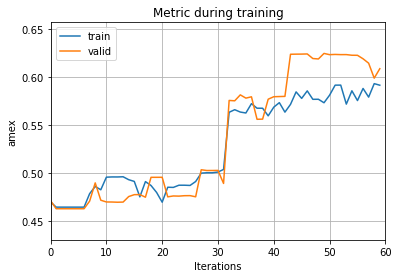

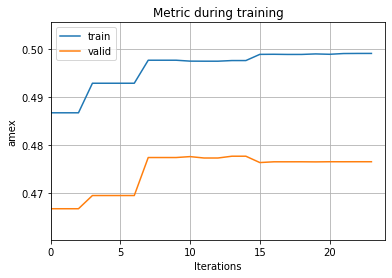

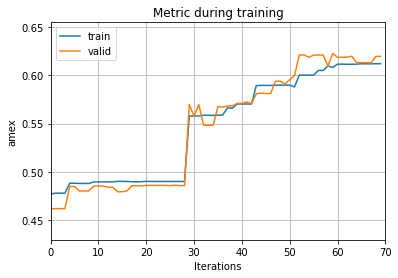

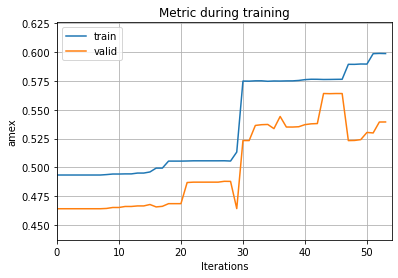

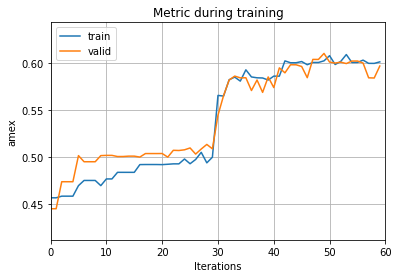

In [71]:
lgb_params = {"learning_rate": 0.01,
              'num_leaves': 127,
              'min_child_samples': 2400}

features = list(train_new.columns)
models = fit_lgbm(train[features], train[Config.target], params=lgb_params)
# models = [joblib.load(f'{EXP_MODEL}/lgbm_fold{i}.pkl') for i in range(Config.n_splits)]
pred = inference_lgbm(models, test[features])

## Plot importance

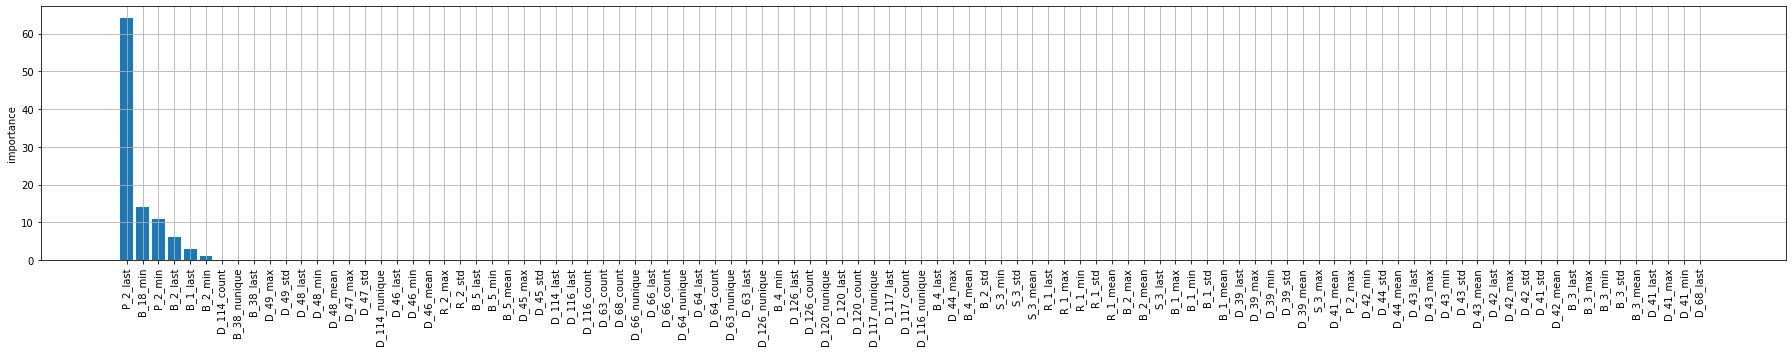

In [72]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

## Submission

In [73]:
sub = pd.DataFrame({'customer_ID': test.index,
                    'prediction': pred})
sub.to_csv(f'{EXP_PREDS}/submission.csv', index=False)

In [74]:
! kaggle competitions submit -c amex-default-prediction -f /home/abe/kaggle/kaggle-amex/submissions/submission.csv -m "Recuresive Feature Elimination for Aggregation Features"

  2%|▊                                      | 8.00k/362k [00:05<03:44, 1.61kB/s]